# July 31, Aug 23, Nov 22 2024: check if chains have converged

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
from numba import jit
import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.type = 'allen' #'spatial'
args.roi_size = 'x' #225
args.maintain_symmetry = True #True
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')

0

In [5]:
SBM_path

'/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/model-fits'

In [6]:
args.dc, args.sbm = False, 'h'

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [7]:
def collect_sbm_files(args, sbm_files):
    sbms_df = []
    for file in tqdm(sbm_files):
        with open(file, 'rb') as f:
            [bs, Bs, Bes, dls] = pickle.load(f)
        
        fs = file.split('/')
        sub = '-'.join([s for s in fs if 'sub-' in s][0].split('-')[1:])
        sbm = [s for s in fs if 'sbm-' in s][0]
        B = [s for s in fs if 'B-' in s][0].split('-')[-1]

        Bes = Bes[0] if args.sbm in ['h'] else Bes
        
        row = pd.DataFrame(dict(
            sub=[sub],
            sbm=[sbm],
            B=[B],
            Bes=[Bes],
        ))
        sbms_df += [row]
        # break
    sbms_df = pd.concat(sbms_df).reset_index(drop=True)
    return sbms_df

sbm_files = sorted(glob.glob(f'{SBM_path}/*/{SBM}/*/desc-partitions.pkl', recursive=True))
sbms_df = collect_sbm_files(args, sbm_files)

100%|██████████| 50/50 [06:54<00:00,  8.29s/it]


In [8]:
sbms_df.head(n=10)

,sub,sbm,B,Bes
0,SLC01,sbm-nd-h,1,"[20.741279021902592, 21.03084676221185, 20.649..."
1,SLC01,sbm-nd-h,122,"[19.040045822029715, 20.345631124903573, 20.38..."
2,SLC01,sbm-nd-h,162,"[19.49842761567977, 19.601070804372423, 21.538..."
3,SLC01,sbm-nd-h,41,"[21.35582451858246, 21.722063051981127, 20.982..."
4,SLC01,sbm-nd-h,82,"[21.186904403693365, 21.39836668363474, 21.072..."
5,SLC02,sbm-nd-h,1,"[21.929473998228207, 22.180635648481037, 22.23..."
6,SLC02,sbm-nd-h,122,"[17.572234972448857, 17.360830806047943, 18.25..."
7,SLC02,sbm-nd-h,162,"[18.65703933111056, 19.71833172473026, 19.8143..."
8,SLC02,sbm-nd-h,41,"[18.81771249493752, 18.927410204097946, 18.775..."
9,SLC02,sbm-nd-h,82,"[21.6271699670119, 21.56286650604627, 21.43117..."


In [11]:
def KSD(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    
    ksds_df = []
    for idx1, idx2 in (combinations(chain_idxs, 2)):
        Bes_ch1 = chains_df.iloc[idx1]['Bes']
        Bes_ch2 = chains_df.iloc[idx2]['Bes']
        Ds = []
        ts = np.arange(10, args.force_niter, 100)
        for t in ts:
            res = stats.ks_2samp(Bes_ch1[:t], Bes_ch2[:t])
            Ds.append(res.statistic)
        df = pd.DataFrame({
            'ch1': [idx1] * len(Ds),
            'ch2': [idx2] * len(Ds),
            't': ts,
            'D': Ds,
        })
        ksds_df.append(df)
    ksds_df = pd.concat(ksds_df).reset_index(drop=True)
    return ksds_df

def plot_KSD(args, chains_df, ksds_df, ax):
    chain_idxs = chains_df.index.to_list()
    Ds = []
    for idx1, idx2 in combinations(chain_idxs, 2):
        t_D = ksds_df[
            (ksds_df['ch1'] == idx1) &
            (ksds_df['ch2'] == idx2)
        ][['t', 'D']].to_numpy()
        Ds += [t_D[:, 1]]
        ax.plot(t_D[:, 0], t_D[:, 1], c='tab:blue')
    Ds = np.stack(Ds, axis=-1)
    ax.plot(t_D[:, 0], np.mean(Ds, axis=-1), c='tab:red', linewidth=3)
    ax.plot(t_D[:, 0], args.epsilon * np.ones_like(t_D[:, 0]), c='tab:grey', linestyle='-.')
    T = Ds.shape[0]
    return np.all(Ds[T//2:, :] < args.epsilon)

def indicate_unmizing(args, ax):
    for spine in ax.spines.values():
        spine.set_color('tab:red')
        spine.set_linewidth(2)
    return None

def trace_plot(args, group, ax):
    for i, r in group.iterrows():
        ax.plot(r['Bes'], label=r['B'])
    return None

def Rhat(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    chains = np.stack(chains_df['Bes'].to_list(), axis=0)
    
    ts = np.arange(10, chains.shape[-1], 100)
    rhats = np.zeros_like(ts)
    for i, t in enumerate(ts):
        rhats[i] = az.rhat(chains[:, :t])
    return ts, rhats

In [12]:
def create_diagnostics_plots(args, sbms_df):
    ncols = 4
    nrows = len(sbms_df['sub'].unique())
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, 
        figsize=(7*ncols+3.5, 4*nrows), width_ratios=[1.5, 1, 1, 1]
    )
    fig.tight_layout(h_pad=3, w_pad=3)

    for idx, (sub, group) in tqdm(enumerate(sbms_df.groupby(by=['sub']))):
        sub = sub[0]
        group = group.reset_index(drop=True)
        group['Bes_conv'] = group['Bes'].apply(lambda x: x[-args.num_draws:])
        display(group)

        # Koomogorov-Smirnov distances
        ax = axs[idx, 1]
        ksds_df = KSD(args, group)
        converged = plot_KSD(args, group, ksds_df, ax)
        ax.set(xlabel=f'MCMC sweep', ylabel=f'KSD')
        if not converged: indicate_unmizing(args, ax)
        
        # trace plots
        ax = axs[idx, 0]
        trace_plot(args, group, ax)
        ax.set(title=f'sub-{sub}', ylabel='$B_e$', xlabel='MCMC sweep')
        ax.legend()
        if not converged: indicate_unmizing(args, ax)

        # Rhat
        ax = axs[idx, 2]
        ts, rhats = Rhat(args, group)
        ax.plot(ts, rhats)
        ax.set(xlabel=f'MCMC sweep', ylabel='$\hat{R}$')
        if not converged: indicate_unmizing(args, ax)

        # posterior distribution
        ax = axs[idx, 3]
        df = group.explode('Bes_conv')
        sns.kdeplot(data=df, x='Bes_conv', hue='B', fill=True, palette='tab10', alpha=0.1, ax=ax)
        if not converged: indicate_unmizing(args, ax)
    return fig

0it [00:00, ?it/s]

,sub,sbm,B,Bes,Bes_conv
0,SLC01,sbm-nd-h,1,"[20.741279021902592, 21.03084676221185, 20.649...","[24.945482815864157, 24.839579559377437, 24.68..."
1,SLC01,sbm-nd-h,122,"[19.040045822029715, 20.345631124903573, 20.38...","[25.75936289223322, 25.794941746007222, 25.939..."
2,SLC01,sbm-nd-h,162,"[19.49842761567977, 19.601070804372423, 21.538...","[23.818432837712727, 23.982774612480583, 23.89..."
3,SLC01,sbm-nd-h,41,"[21.35582451858246, 21.722063051981127, 20.982...","[24.821318301928482, 24.675788544212054, 24.80..."
4,SLC01,sbm-nd-h,82,"[21.186904403693365, 21.39836668363474, 21.072...","[25.048187431473245, 24.600563364829917, 24.67..."


1it [00:55, 55.74s/it]

,sub,sbm,B,Bes,Bes_conv
0,SLC02,sbm-nd-h,1,"[21.929473998228207, 22.180635648481037, 22.23...","[23.046586171972898, 23.219318917690092, 22.99..."
1,SLC02,sbm-nd-h,122,"[17.572234972448857, 17.360830806047943, 18.25...","[22.360272117112345, 22.060736074280506, 22.11..."
2,SLC02,sbm-nd-h,162,"[18.65703933111056, 19.71833172473026, 19.8143...","[22.744990041939, 22.907690083659844, 22.70849..."
3,SLC02,sbm-nd-h,41,"[18.81771249493752, 18.927410204097946, 18.775...","[22.29577968655518, 22.146388820189493, 22.344..."
4,SLC02,sbm-nd-h,82,"[21.6271699670119, 21.56286650604627, 21.43117...","[23.043726531045294, 22.8684056077357, 23.1276..."


2it [02:18, 71.69s/it]

,sub,sbm,B,Bes,Bes_conv
0,SLC03,sbm-nd-h,1,"[18.212687380386967, 19.308237047121484, 19.35...","[25.02946404965078, 24.95196944572781, 24.7421..."
1,SLC03,sbm-nd-h,122,"[19.271102590723157, 19.77186676396045, 19.910...","[21.960553855993084, 22.1404780473167, 22.3954..."
2,SLC03,sbm-nd-h,162,"[21.087429113026243, 21.086656849245294, 20.53...","[23.76408518970701, 23.48225494600889, 23.3956..."
3,SLC03,sbm-nd-h,41,"[21.940631371814327, 21.781984655757704, 21.96...","[23.590417932349933, 23.644320049658788, 23.54..."
4,SLC03,sbm-nd-h,82,"[20.112742932563215, 19.827979976933516, 19.61...","[24.83714702546018, 24.885851005167076, 24.915..."


3it [02:58, 57.16s/it]

,sub,sbm,B,Bes,Bes_conv
0,SLC04,sbm-nd-h,1,"[26.340171106191146, 26.829613799741477, 26.15...","[23.434833598679937, 23.533638923269386, 23.47..."
1,SLC04,sbm-nd-h,122,"[20.54206592175188, 21.446370048571897, 21.614...","[23.486546262269744, 23.370764614279, 23.18621..."
2,SLC04,sbm-nd-h,162,"[23.175857371194653, 22.279138874762438, 22.32...","[22.9045579697698, 23.15396078130308, 23.60261..."
3,SLC04,sbm-nd-h,41,"[18.68366346921234, 18.8156581409102, 19.97911...","[23.21488326337077, 23.341966801728297, 23.119..."
4,SLC04,sbm-nd-h,82,"[20.960246196708358, 21.391315287006996, 21.17...","[23.61639541271039, 23.27137009202819, 23.2757..."


4it [04:05, 61.05s/it]

,sub,sbm,B,Bes,Bes_conv
0,SLC05,sbm-nd-h,1,"[16.523739832570744, 16.85327170988637, 16.583...","[19.002782639623685, 19.148559621136826, 19.10..."
1,SLC05,sbm-nd-h,122,"[16.15511531865815, 16.045036738676828, 17.265...","[17.85514619764462, 17.616109151544602, 17.968..."
2,SLC05,sbm-nd-h,162,"[18.90997225318063, 18.788148324427105, 18.914...","[18.61901646125449, 18.572756999781532, 18.568..."
3,SLC05,sbm-nd-h,41,"[16.951369097176, 16.801006272622818, 16.82785...","[17.334409261013704, 17.358986962440063, 17.40..."
4,SLC05,sbm-nd-h,82,"[15.940150231516885, 16.375702024063223, 16.34...","[17.648670059078057, 18.008395622917075, 18.18..."


5it [05:21, 66.36s/it]

,sub,sbm,B,Bes,Bes_conv
0,SLC06,sbm-nd-h,1,"[19.665268040080008, 19.18653298575598, 19.858...","[19.34801695003455, 19.04959900609308, 19.0509..."
1,SLC06,sbm-nd-h,122,"[16.193452072757253, 16.064682349027834, 15.92...","[18.8603396353753, 18.868180305459415, 19.2742..."
2,SLC06,sbm-nd-h,162,"[15.95875209682104, 15.974582734947182, 15.884...","[20.120515896513016, 20.241777865284373, 20.42..."
3,SLC06,sbm-nd-h,41,"[17.855704362803824, 17.338759393909903, 18.04...","[19.58051617751327, 19.387606957331894, 19.387..."
4,SLC06,sbm-nd-h,82,"[16.7033704406124, 16.60938000913661, 16.56731...","[18.78664658646081, 18.778238263915572, 18.778..."


6it [06:35, 69.20s/it]

,sub,sbm,B,Bes,Bes_conv
0,SLC07,sbm-nd-h,1,"[15.741969817229405, 16.08798002876356, 15.794...","[18.07530344555467, 17.887653563373465, 18.075..."
1,SLC07,sbm-nd-h,122,"[18.022343402279898, 18.111406982181286, 18.31...","[18.2628292884721, 18.104224334374056, 18.0355..."
2,SLC07,sbm-nd-h,162,"[14.892495360259765, 14.997881462618869, 15.14...","[17.16890875381535, 17.281743302715594, 17.414..."
3,SLC07,sbm-nd-h,41,"[15.225054513990658, 15.1145489017805, 15.2871...","[17.358724458002968, 17.270559920701295, 17.21..."
4,SLC07,sbm-nd-h,82,"[16.301752392807103, 16.357712145836437, 16.52...","[18.25402314361745, 18.129152519149756, 18.150..."


7it [07:32, 65.19s/it]

,sub,sbm,B,Bes,Bes_conv
0,SLC08,sbm-nd-h,1,"[16.153081226482282, 15.994355365127452, 16.19...","[18.151830907156224, 18.088885776499765, 18.07..."
1,SLC08,sbm-nd-h,122,"[14.613816194158929, 15.735546623232821, 15.94...","[18.20570523606767, 17.99075508820582, 17.9960..."
2,SLC08,sbm-nd-h,162,"[17.082555173079136, 17.770819665825165, 17.89...","[16.689524334445867, 16.739569398096172, 16.74..."
3,SLC08,sbm-nd-h,41,"[14.532613454719915, 14.390188537877846, 14.57...","[17.560299288616037, 17.64358533220356, 17.714..."
4,SLC08,sbm-nd-h,82,"[17.091759218079414, 17.12312349927619, 17.136...","[18.762786070834775, 18.664963461171485, 18.71..."


8it [08:24, 60.78s/it]

,sub,sbm,B,Bes,Bes_conv
0,SLC09,sbm-nd-h,1,"[15.837909306814439, 17.056856376994812, 16.86...","[20.243744282098067, 18.913196371000744, 18.84..."
1,SLC09,sbm-nd-h,122,"[19.979336521397265, 19.862789502185095, 19.65...","[21.18606604783026, 20.86905872392091, 20.8088..."
2,SLC09,sbm-nd-h,162,"[19.891647201857772, 19.834903362642645, 20.00...","[19.626858789954206, 19.578095316334725, 19.51..."
3,SLC09,sbm-nd-h,41,"[17.70068478319359, 17.67894340952516, 17.5729...","[18.72040621927372, 18.688996493389972, 18.627..."
4,SLC09,sbm-nd-h,82,"[21.86841178455094, 21.8040001687706, 21.86372...","[19.697387590425084, 19.67063165599116, 19.728..."


9it [09:31, 62.71s/it]

,sub,sbm,B,Bes,Bes_conv
0,SLC10,sbm-nd-h,1,"[14.836482348843793, 14.81040835178999, 14.815...","[15.78365321138011, 15.876718560912378, 15.952..."
1,SLC10,sbm-nd-h,122,"[16.521742196231916, 16.719092339598753, 16.59...","[16.780158421800305, 16.778363023782575, 16.73..."
2,SLC10,sbm-nd-h,162,"[16.397119722465117, 16.406783721997986, 16.04...","[16.847739563494027, 16.980803094684877, 16.79..."
3,SLC10,sbm-nd-h,41,"[18.40745031326792, 18.4375297266463, 18.98289...","[15.609090298928248, 15.597265801072055, 15.55..."
4,SLC10,sbm-nd-h,82,"[10.640519981096496, 12.50996743261443, 12.515...","[18.195456050468284, 18.15628240931431, 18.272..."


10it [10:35, 63.57s/it]


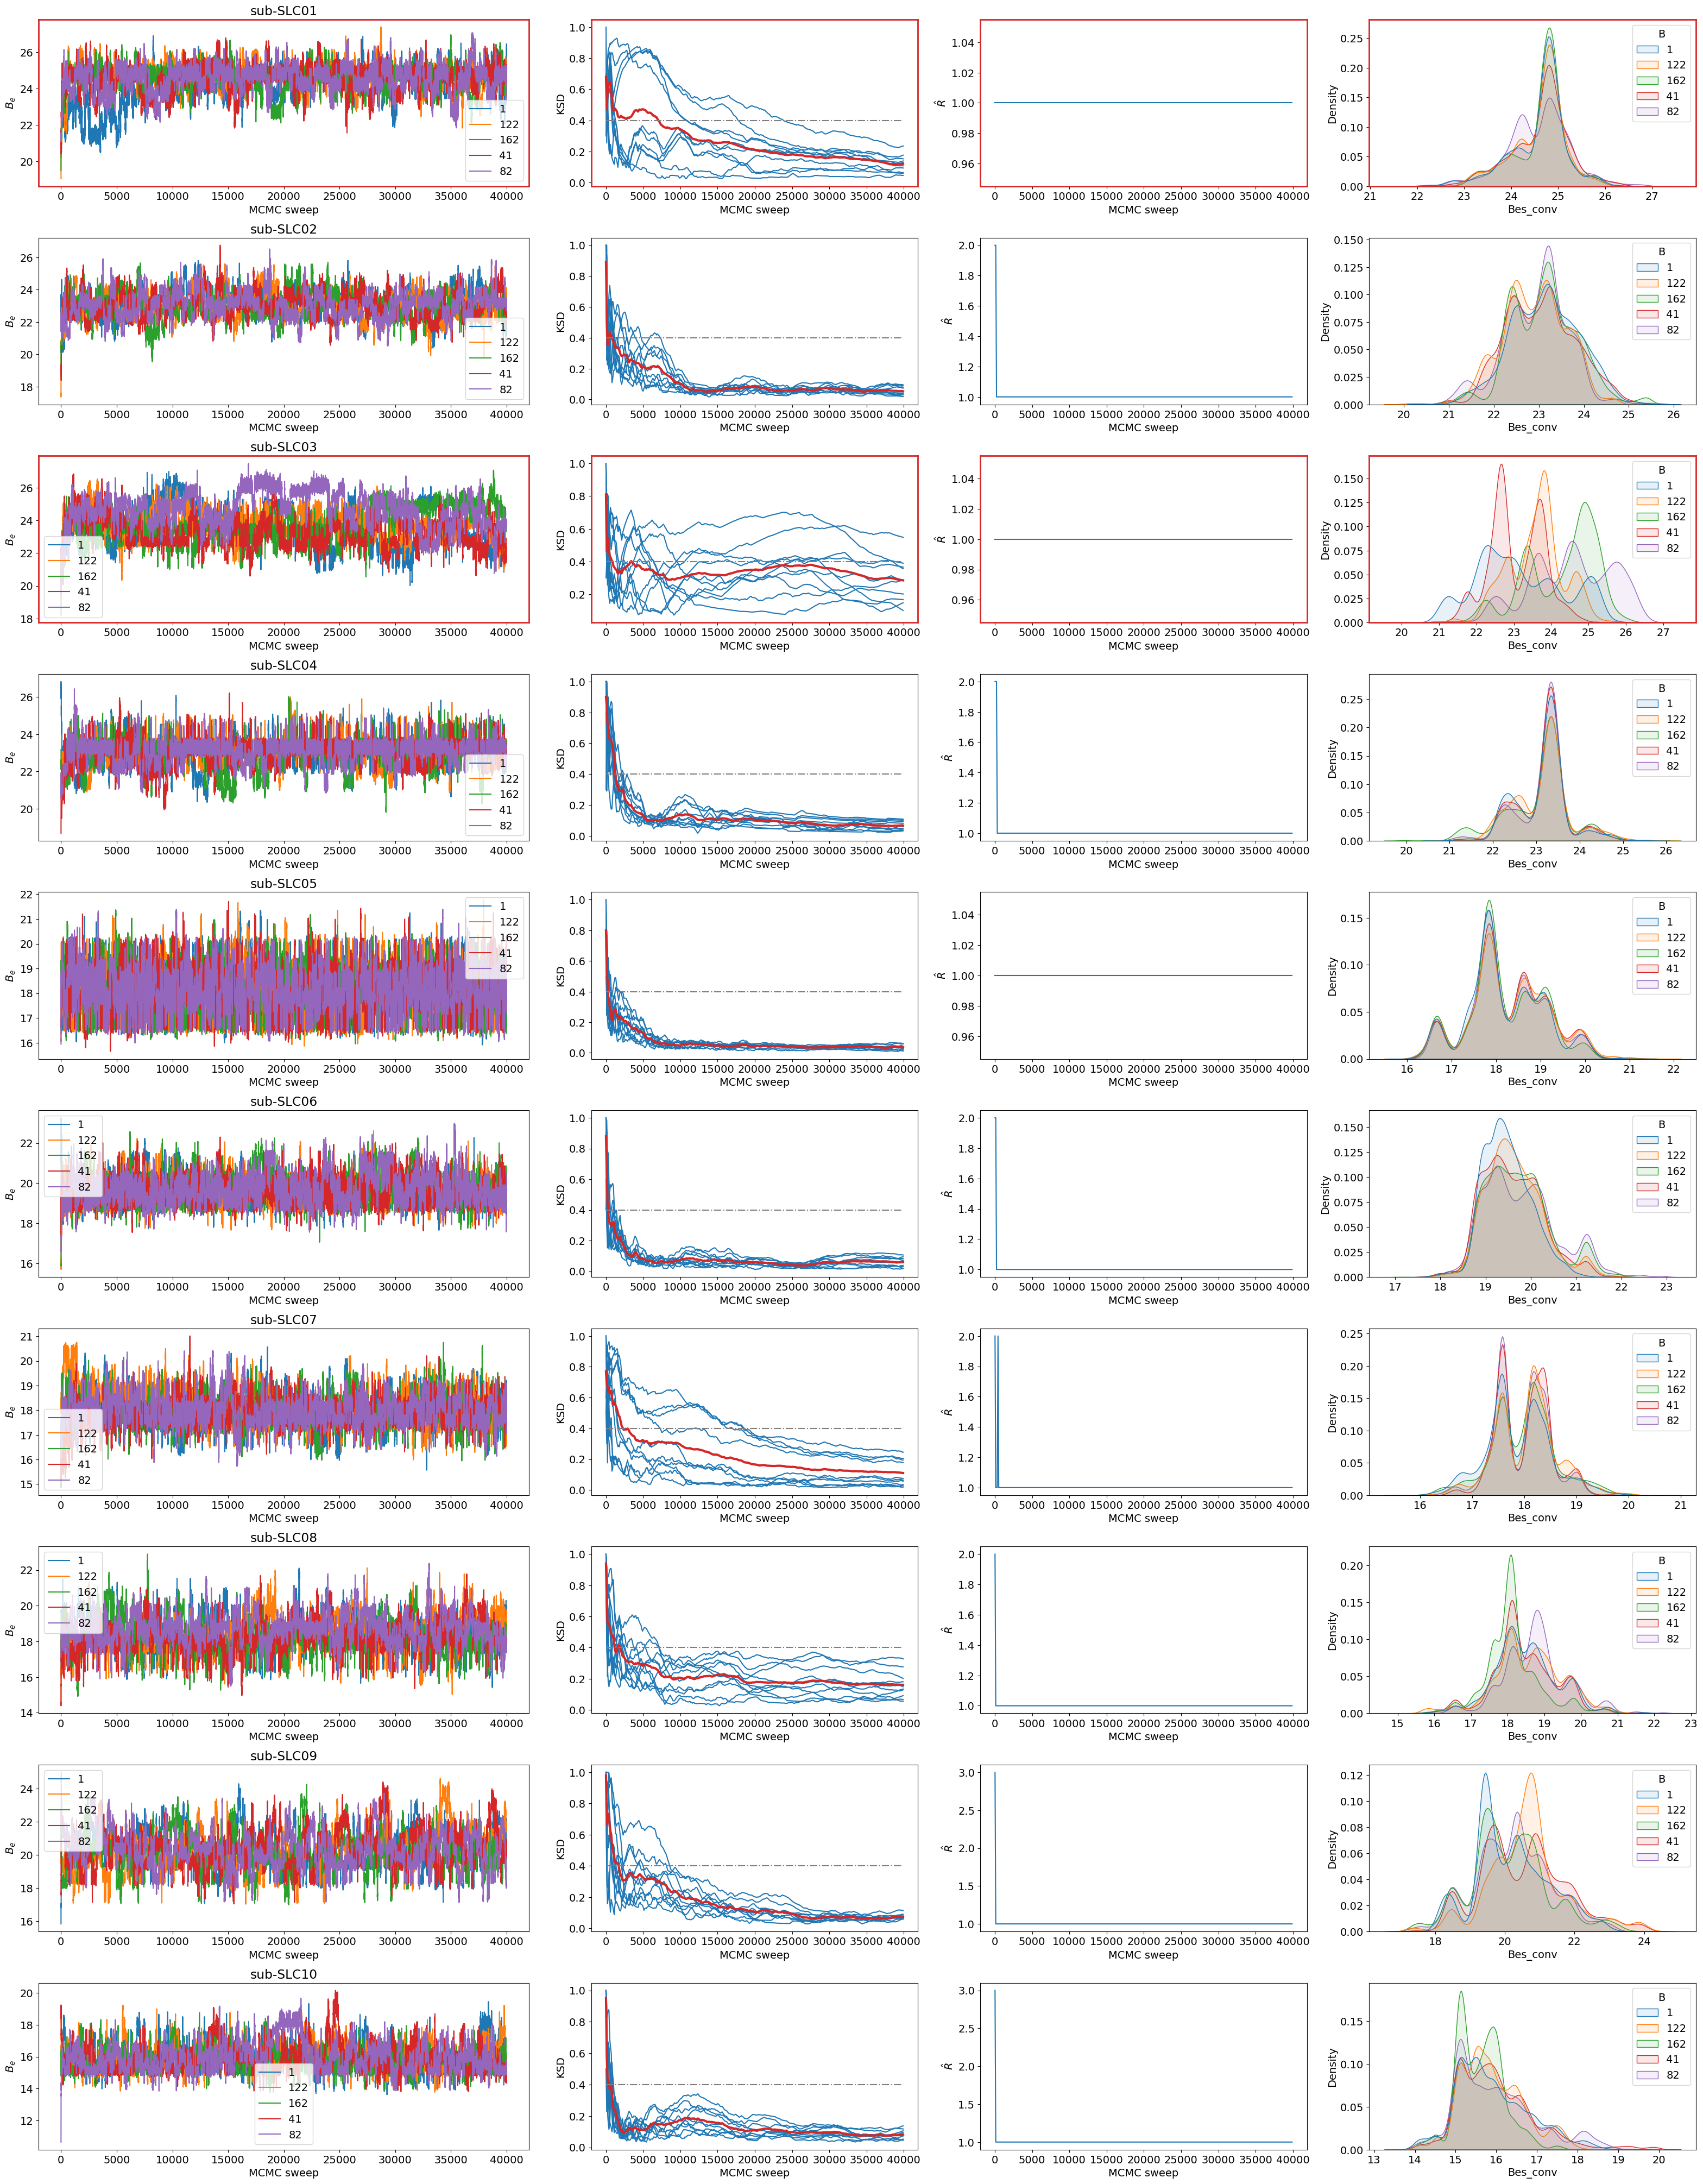

In [13]:
figfile = f'{DIAG_path}/{SBM}_desc-diagnostics.png'
if os.path.exists(figfile):
    display(Image(figfile))
else:
    fig = create_diagnostics_plots(args, sbms_df)

In [14]:
fig.savefig(f'{DIAG_path}/{SBM}_desc-trace-KSD-Rhat-dist.png', bbox_inches='tight')